In [105]:
import pandas as pd
import networkit as nk
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


In [4]:
# Load the graph from the .graphml file
G = nk.graphio.readGraph("graphs/all.graphml", nk.Format.GraphML)

# Compute centralities
degree_centralities = nk.centrality.DegreeCentrality(G).run().scores()

In [ ]:
import networkx as nx
G = nx.read_graphml("graphs/all.graphml")

# get the nodes' names
nodes = G.nodes()

In [114]:
# Create DataFrame to store the centrality measures
centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centralities
})

# Set the nodes as the index of the DataFrame
centrality_df.index = nodes

In [115]:
# label index as 'researcher_id'
centrality_df.index.name = 'researcher_id'
centrality_df = centrality_df.sort_values(by='Degree Centrality', ascending=False)
centrality_df['rank'] = centrality_df['Degree Centrality'].rank(ascending=False, pct=True)


In [116]:
# load cleaned data
clean_data = pd.read_csv('../data_light/data_clean.csv')

# merged centrality_df with clean_data for LMIC and gender columns
centrality_df = centrality_df.merge(clean_data[['researcher_id', 'LMIC', 'gender']], on='researcher_id')

In [117]:
centrality_df.head()

,researcher_id,Degree Centrality,rank,LMIC,gender
0,ur.012310237337.47,980.0,0.000006,0,male
1,ur.012310237337.47,980.0,0.000006,0,male
2,ur.012310237337.47,980.0,0.000006,0,male
3,ur.012310237337.47,980.0,0.000006,0,male
4,ur.012310237337.47,980.0,0.000006,0,male


In [37]:
# select top 10%
centrality_df_01 = centrality_df[centrality_df['rank'] <= 0.05]

80


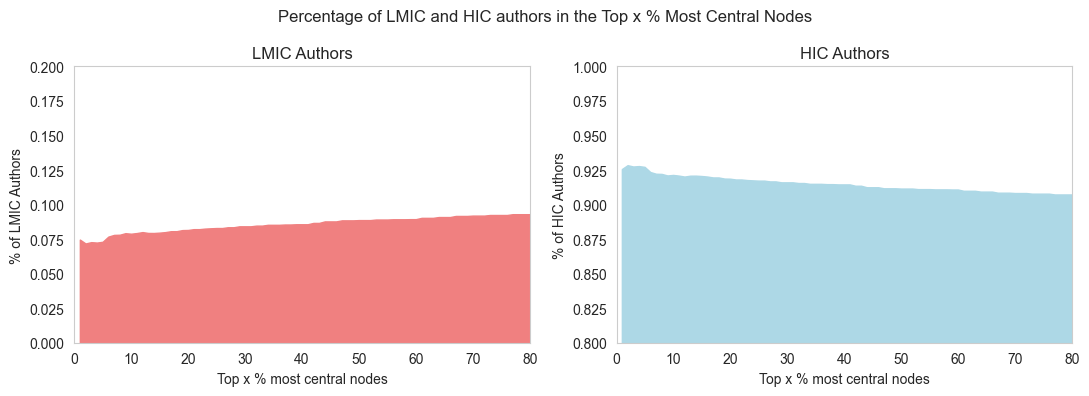

In [172]:
# get the distributions of LMIC and HIC for the top x% of authors
lmic_percentages = []
hic_percentages = []
pvalues_signif = []
for i in range(1, 101):
    centrality_df_i = centrality_df[centrality_df['rank'] <= i/100]
    hic_percentages.append(centrality_df_i['LMIC'].value_counts(normalize=True)[0])
    lmic_percentages.append(centrality_df_i['LMIC'].value_counts(normalize=True)[1])
    # t test for LMIC vs HIC, register as 1 if p-value < 0.05, 0 otherwise
    pvalue = ttest_ind(centrality_df_i['LMIC'], centrality_df['LMIC']).pvalue
    if pvalue < 0.05:
        pvalues_signif.append(1)
    else:
        pvalues_signif.append(0)

# print position nonsignificant pvalue
th_significance_from_all_set = pvalues_signif.index(0)
print(th_significance_from_all_set)

# figure with two plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.plot(range(1, 101), lmic_percentages, color='firebrick', alpha=0)
# ax1.vlines(th_significance_from_all_set, ymin=0, ymax=1, color='black', linestyle='--', linewidth=.75)
# ax2.vlines(th_significance_from_all_set, ymin=0, ymax=1, color='black', linestyle='--', linewidth=.75)
# # add a text at the position of the first nonsignificant pvalue
# ax1.text(th_significance_from_all_set+1.5, 0.175, "p-value > 0.05\ntop x% vs 100%", fontsize=8)
# ax2.text(th_significance_from_all_set+1.5, 0.975, "p-value > 0.05\ntop x% vs 100%", fontsize=8)
ax1.set_xlim(0,  th_significance_from_all_set)
ax1.set_ylim(0, .2)
ax2.plot(range(1, 101), hic_percentages, color='royalblue', alpha=0)
ax2.set_xlim(0,th_significance_from_all_set)
ax2.set_ylim(.8, 1)
ax1.set_xlabel('Top x % most central nodes')
ax2.set_xlabel('Top x % most central nodes')
ax1.set_ylabel('% of LMIC Authors')
ax2.set_ylabel('% of HIC Authors')
ax1.set_title('LMIC Authors')
ax2.set_title('HIC Authors')
fig.suptitle('Percentage of LMIC and HIC authors in the Top x % Most Central Nodes')
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
ax1.fill_between(range(1, 101), lmic_percentages, color='lightcoral')
ax2.fill_between(range(1, 101), hic_percentages, color='lightblue')
# fill after vertical line
# ax1.fill_between(range(th_significance_from_all_set, 101), lmic_percentages[th_significance_from_all_set-1:], color='gainsboro')
# ax2.fill_between(range(th_significance_from_all_set, 101), hic_percentages[th_significance_from_all_set-1:], color='gainsboro')
plt.savefig('results/centrality_LMIC.png', dpi=300)


In [119]:
# transform gender into binary, 0 or 1
centrality_df.gender = centrality_df.gender.apply(lambda x: 1 if x == "female" else 0) 

76


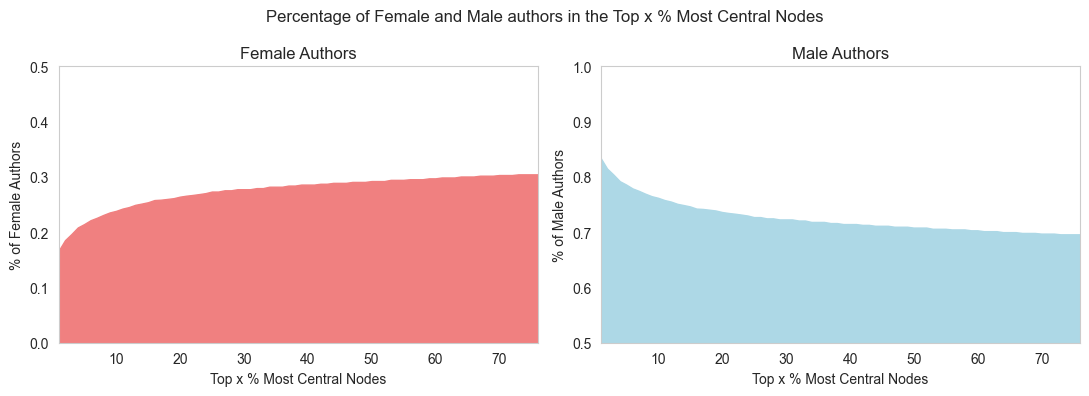

In [171]:
# get the distributions of LMIC and HIC for the top x% of authors
female_percentages = []
male_percentages = []
pvalues_signif = []
for i in range(1, 101):
    centrality_df_i = centrality_df[centrality_df['rank'] <= i/100]
    female_percentages.append(centrality_df_i['gender'].value_counts(normalize=True)[1])
    male_percentages.append(centrality_df_i['gender'].value_counts(normalize=True)[0])
    # t test for LMIC vs HIC, register as 1 if p-value < 0.05, 0 otherwise    
    pvalue = ttest_ind(centrality_df_i['gender'], centrality_df['gender']).pvalue

    if pvalue < 0.05:
        pvalues_signif.append(1)
    else:
        pvalues_signif.append(0)

# print position nonsignificant pvalue
th_significance_from_all_set = pvalues_signif.index(0)
print(th_significance_from_all_set)

# figure with two plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.plot(range(1, 101), female_percentages, color='firebrick', alpha=0)
# add a vertical line at the position of the first nonsignificant pvalue
# ax1.vlines(th_significance_from_all_set, ymin=0, ymax=1, color='black', linestyle='--', linewidth=.75)
# ax2.vlines(th_significance_from_all_set, ymin=0, ymax=1, color='black', linestyle='--', linewidth=.75)
# # add a text at the position of the first nonsignificant pvalue
# ax1.text(th_significance_from_all_set+1.5, 0.45, "p-value > 0.05\ntop x% vs 100%", fontsize=8)
# ax2.text(th_significance_from_all_set+1.5, 0.95, "p-value > 0.05\ntop x% vs 100%", fontsize=8)
ax1.set_xlim(1,  th_significance_from_all_set)
ax1.set_ylim(0,.5)
ax2.set_ylim(.5,1)
ax2.plot(range(1, 101), male_percentages, color='royalblue', alpha=0)
ax2.set_xlim(1,th_significance_from_all_set)
ax1.set_xlabel('Top x % Most Central Nodes')
ax2.set_xlabel('Top x % Most Central Nodes')
ax1.set_ylabel('% of Female Authors')
ax2.set_ylabel('% of Male Authors')
ax1.set_title('Female Authors')
ax2.set_title('Male Authors')
fig.suptitle('Percentage of Female and Male authors in the Top x % Most Central Nodes')
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
ax1.fill_between(range(1, 101), female_percentages, color='lightcoral')
ax2.fill_between(range(1, 101), male_percentages, color='lightblue')
# fill after vertical line
# ax1.fill_between(range(th_significance_from_all_set, 101), female_percentages[th_significance_from_all_set-1:], color='gainsboro')
# ax2.fill_between(range(th_significance_from_all_set, 101), male_percentages[th_significance_from_all_set-1:], color='gainsboro')
plt.savefig('results/centrality_gender.png', dpi=300)




